<a href="https://colab.research.google.com/github/IvanMegia/bird_strike_analysis/blob/main/TFM_Bird_Strike_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARIES, FUNCTIONS AND GOOGLE DRIVE MOUNT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
!pip install openpyxl
!pip install geopandas
!pip install plotnine
from plotnine import *
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import itertools
import multiprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score, roc_auc_score, recall_score
from sklearn.model_selection import GridSearchCV
pd.options.display.max_columns = None
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

     |████████████████████████████████| 1.0 MB 17.7 MB/s 
     |████████████████████████████████| 16.7 MB 320 kB/s 
     |████████████████████████████████| 6.3 MB 45.4 MB/s 


In [2]:
np.random.seed(10)

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
df_bird_strikes = pd.read_csv('/content/gdrive/MyDrive/TFM/bird_strike_cleaned.csv',
                 delimiter = ',', na_values = ['NA','UNKNOWN','','na'])
print('Model dimensions are: ', df_bird_strikes.shape)
df_bird_strikes.head()

Model dimensions are:  (250080, 57)


,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,SKY,INGESTED,INDICATED_DAMAGE,STR_RAD,DAM_RAD,STR_WINDSHLD,DAM_WINDSHLD,STR_NOSE,DAM_NOSE,STR_PROP,DAM_PROP,STR_WING_ROT,DAM_WING_ROT,STR_FUSE,DAM_FUSE,STR_LG,DAM_LG,STR_TAIL,DAM_TAIL,STR_LGHTS,DAM_LGHTS,STR_OTHER,DAM_OTHER,OTHER_SPECIFY,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,STATE,AIRCRAFT_TYPE,AIRCRAFT,AC_CLASS,TYPE_ENG,PHASE_OF_FLIGHT,HEIGHT_ft,HEIGHT_m,SPEED_knot_IAS,SPEED_km/h_IAS,DISTANCE_NM,DISTANCE_KM,STR_ENGINE,DAM_ENGINE,ING_ENGINE,DAMAGE_LEVEL,EFFECT,EFFECT_OTHER,INCIDENT_TYPE,SPECIES,WARNED,NUM_SEEN,NUM_STRUCK,SIZE,ENROUTE_STATE,NR_FATALITIES
0,KMIE,DELAWARE COUNTY REGIONAL ARPT,40.24235,-85.39586,No Cloud,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,1990-10-15,10,1990,IN,C-172,CESSNA 172,Airplane,Piston,Approach,200.0,60.96,70.0,129.64,NaN,NaN,False,False,False,No damage,None,NaN,Non-serious,Unknown bird,No,1,1,Small,Not En Route,0.0
1,KMSY,LOUIE ARMSTRONG NEW ORLEANS INTL ARPT,29.99339,-90.25803,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,1993-01-08,1,1993,LA,B-727,B-727,Airplane,Turbofan,Landing Roll,0.0,0.00,NaN,NaN,0.0,0.000,False,False,False,No damage,None,NaN,Non-serious,Unknown bird,Unknown,NaN,1,Medium,Not En Route,0.0
2,KORD,CHICAGO O'HARE INTL ARPT,41.97960,-87.90446,NaN,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,1996-08-18,8,1996,IL,B-757-200,B-757,Airplane,Turbofan,Landing Roll,0.0,0.00,NaN,NaN,0.0,0.000,False,False,False,No damage,None,NaN,Non-serious,Blackbirds,Unknown,NaN,1,Small,Not En Route,0.0
3,KMHT,MANCHESTER AIRPORT,42.93452,-71.43706,No Cloud,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,1993-09-19,9,1993,NH,BE-33,BE-33,Airplane,Piston,Approach,1800.0,548.64,150.0,277.80,8.0,14.816,False,False,False,Substantial,Precautionary Landing,NaN,Serious,Unknown bird,No,2-10,1,Large,Not En Route,0.0
4,KELP,EL PASO INTL ARPT,31.80667,-106.37781,No Cloud,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,NaN,1991-03-23,3,1991,TX,B-727,B-727,Airplane,Turbofan,Approach,200.0,60.96,135.0,250.02,NaN,NaN,False,False,False,No damage,None,NaN,Non-serious,Unknown bird,No,NaN,1,Small,Not En Route,0.0


# PCA

First try:

In [ ]:
df_PCA = df_bird_strikes
to_discard = ['OTHER_SPECIFY', 'INCIDENT_DATE', 'HEIGHT_ft', 'SPEED_knot_IAS', 'DISTANCE_NM', 'EFFECT_OTHER', 'INCIDENT_TYPE', 'NUM_SEEN', 'NUM_STRUCK', 'DISTANCE_KM',
              'PHASE_OF_FLIGHT', 'WARNED', 'INCIDENT_YEAR', 'AIRCRAFT_TYPE', 'AIRPORT_ID']
df_PCA = df_PCA.drop(columns = to_discard, inplace = False)
df_PCA.dropna(inplace = True)
df_PCA.shape

(70445, 42)

First try: only for numerical variables

In [ ]:
df_PCA_cont = df_bird_strikes
float_variables = [column for column in df_PCA_cont.columns if df_PCA_cont[column].dtype == 'float64']
df_PCA_cont = df_PCA_cont[float_variables + ['DAMAGE_LEVEL', 'STATE']]
df_PCA_cont.drop(columns = ['HEIGHT_ft', 'SPEED_knot_IAS', 'DISTANCE_NM'], inplace = True)
float_variables = [column for column in df_PCA_cont.columns if df_PCA_cont[column].dtype == 'float64']
df_PCA_cont.dropna(inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
float_variables

['LATITUDE',
 'LONGITUDE',
 'HEIGHT_m',
 'SPEED_km/h_IAS',
 'DISTANCE_KM',
 'NR_FATALITIES']

In [ ]:
df_PCA_cont.shape

(48244, 8)

In [ ]:
scalar = preprocessing.StandardScaler()

# fitting
scalar.fit(df_PCA_cont[float_variables].values)
scaled_data = scalar.transform(df_PCA_cont[float_variables].values)
 
pca = PCA(n_components = 6)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
  
x_pca.shape

(48244, 6)

In [ ]:
pca.explained_variance_ratio_

array([0.41175504, 0.1743535 , 0.16668166, 0.1588605 , 0.063886  ,
       0.02446331])

In [ ]:
pca.components_[0]

array([ 0.00194752,  0.04474876,  0.59964453,  0.54545644,  0.58385917,
       -0.00243617])

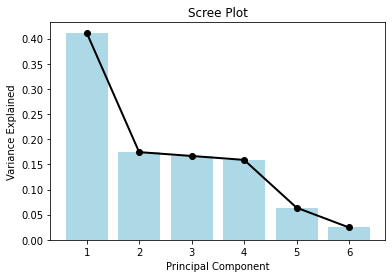

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='black')
plt.bar(PC_values, pca.explained_variance_ratio_, color = 'lightblue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/scree_plot.eps', bbox_inches="tight", format='eps')

In [ ]:
PCA_loadings = {'Variable': float_variables,
                'PC1': pca.components_[0],
                'PC2': pca.components_[1],
                'PC3': pca.components_[2],
                'PC4': pca.components_[3],
                'PC5': pca.components_[4],
                'PC6': pca.components_[5],
                }
PCA_loadings = pd.DataFrame(PCA_loadings)
PCA_loadings

,Variable,PC1,PC2,PC3,PC4,PC5,PC6
0,LATITUDE,0.001948,-0.718760,0.032026,-0.692949,-0.046605,0.001849
1,LONGITUDE,0.044749,0.692172,0.032419,-0.718690,0.034643,-0.011316
2,HEIGHT_m,0.599645,-0.039698,0.000881,0.023504,0.258432,-0.755983
3,SPEED_km/h_IAS,0.545456,0.032708,-0.001029,0.023353,-0.823606,0.150114
4,DISTANCE_KM,0.583859,-0.040435,0.001633,0.011628,0.501509,0.637043
5,NR_FATALITIES,-0.002436,0.000715,0.998959,0.045524,-0.001526,0.000088


In [ ]:
PCA_contributions = {'Variable': float_variables,
                'Cont_PC1': pca.components_[0]**2,
                'Cont_PC2': pca.components_[1]**2,
                'Cont_PC3': pca.components_[2]**2,
                'Cont_PC4': pca.components_[3]**2,
                'Cont_PC5': pca.components_[4]**2,
                'Cont_PC6': pca.components_[5]**2,
                }
PCA_contributions = pd.DataFrame(PCA_contributions)
PCA_contributions

,Variable,Cont_PC1,Cont_PC2,Cont_PC3,Cont_PC4,Cont_PC5,Cont_PC6
0,LATITUDE,0.000004,5.166163e-01,1.025674e-03,0.480179,0.002172,3.417981e-06
1,LONGITUDE,0.002002,4.791025e-01,1.051000e-03,0.516516,0.001200,1.280612e-04
2,HEIGHT_m,0.359574,1.575905e-03,7.762652e-07,0.000552,0.066787,5.715104e-01
3,SPEED_km/h_IAS,0.297523,1.069798e-03,1.057977e-06,0.000545,0.678327,2.253422e-02
4,DISTANCE_KM,0.340892,1.635008e-03,2.665747e-06,0.000135,0.251512,4.058239e-01
5,NR_FATALITIES,0.000006,5.110489e-07,9.979188e-01,0.002072,0.000002,7.763928e-09


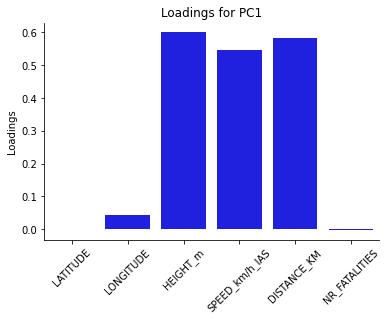

In [ ]:
sns.barplot(x = float_variables,
            y = pca.components_[0],
            color = 'blue')
plt.xticks(rotation = 45)
plt.title('Loadings for PC1')
plt.ylabel('Loadings')
sns.despine()
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/loadings_PC1.eps', bbox_inches="tight", format='eps')

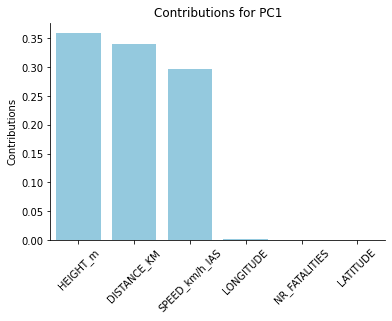

In [ ]:
sns.barplot(x = PCA_contributions.sort_values('Cont_PC1', ascending = False)['Variable'].to_list(),
            y = PCA_contributions.sort_values('Cont_PC1', ascending = False)['Cont_PC1'].values,
            color = 'skyblue')
plt.xticks(rotation = 45)
plt.title('Contributions for PC1')
plt.ylabel('Contributions')
sns.despine()
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/contributions_PC1.eps', bbox_inches="tight", format='eps')

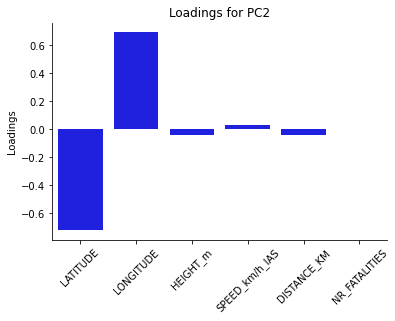

In [ ]:
sns.barplot(x = float_variables,
            y = pca.components_[1],
            color = 'blue')
plt.xticks(rotation = 45)
plt.title('Loadings for PC2')
plt.ylabel('Loadings')
sns.despine()
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/loadings_PC2.eps', bbox_inches="tight", format='eps')

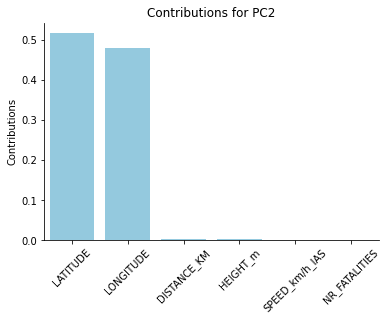

In [ ]:
sns.barplot(x = PCA_contributions.sort_values('Cont_PC2', ascending = False)['Variable'].to_list(),
            y = PCA_contributions.sort_values('Cont_PC2', ascending = False)['Cont_PC2'].values,
            color = 'skyblue')
plt.xticks(rotation = 45)
plt.title('Contributions for PC2')
plt.ylabel('Contributions')
sns.despine()
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/contributions_PC2.eps', bbox_inches="tight", format='eps')

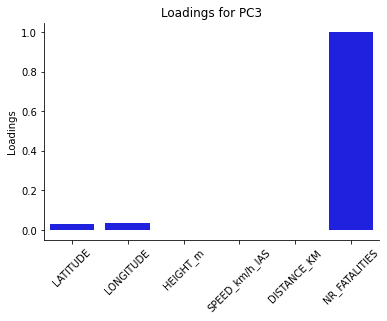

In [ ]:
sns.barplot(x = float_variables,
            y = pca.components_[2],
            color = 'blue')
plt.xticks(rotation = 45)
plt.title('Loadings for PC3')
plt.ylabel('Loadings')
sns.despine()
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/loadings_PC3.eps', bbox_inches="tight", format='eps')

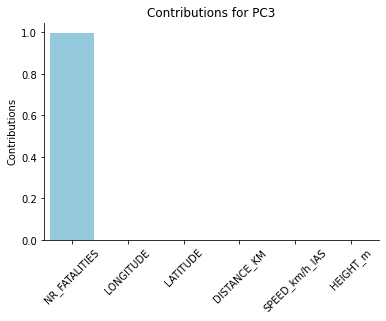

In [ ]:
sns.barplot(x = PCA_contributions.sort_values('Cont_PC3', ascending = False)['Variable'].to_list(),
            y = PCA_contributions.sort_values('Cont_PC3', ascending = False)['Cont_PC3'].values,
            color = 'skyblue')
plt.xticks(rotation = 45)
plt.title('Contributions for PC3')
plt.ylabel('Contributions')
sns.despine()
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/contributions_PC3.eps', bbox_inches="tight", format='eps')

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


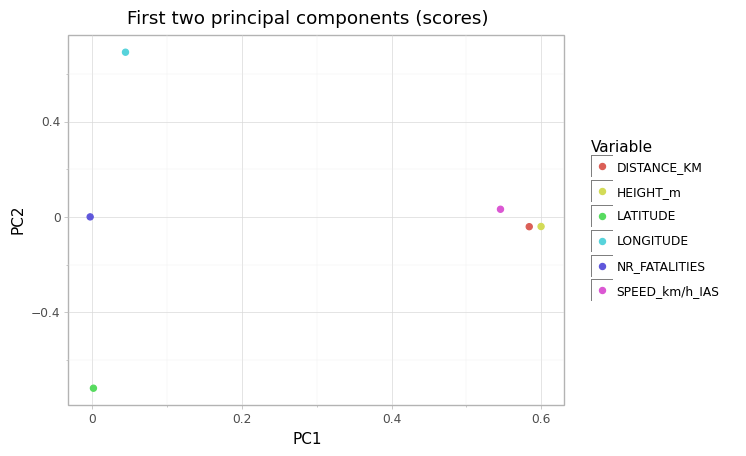

<ggplot: (8741096543965)>

In [ ]:
p = (ggplot(PCA_loadings, aes(x = 'PC1', y ='PC2', color = 'Variable')) +
     geom_point(size=2) +
  labs(title="First two principal components (scores)", x="PC1", y="PC2") + 
  theme_light())
p

In [ ]:
df_PCA_cont['z1'] = x_pca[:, 0]
df_PCA_cont['z2'] = x_pca[:, 1]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /content/gdrive/MyDrive/TFM/plots/PCA/data_projected_all_damages.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


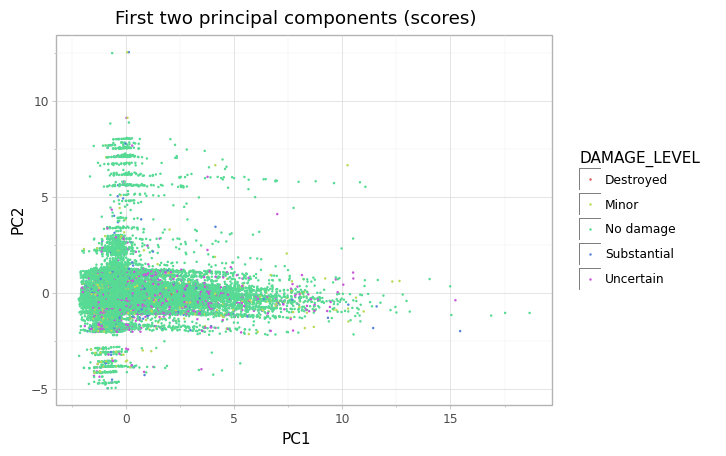

<ggplot: (8741096492713)>

In [ ]:
p = (ggplot(df_PCA_cont, aes(x = 'z1', y = 'z2', color = 'DAMAGE_LEVEL')) +
     geom_point(size=0) +
  labs(title="First two principal components (scores)", x="PC1", y="PC2") + 
  theme_light())
ggsave(plot = p, filename='data_projected_all_damages.png', device = 'png', path = '/content/gdrive/MyDrive/TFM/plots/PCA', ddpi =1000)
p

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /content/gdrive/MyDrive/TFM/plots/PCA/data_projected_only_damaged.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


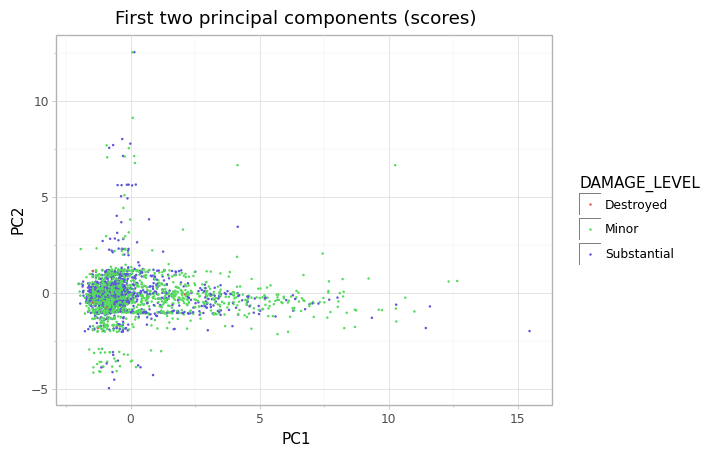

<ggplot: (8741096518489)>

In [ ]:
df_PCA_cont_no_damage = df_PCA_cont.loc[(df_PCA_cont['DAMAGE_LEVEL'] != 'No damage') & (df_PCA_cont['DAMAGE_LEVEL'] != 'Uncertain'), :]

p = (ggplot(df_PCA_cont_no_damage, aes(x = 'z1', y = 'z2', color = 'DAMAGE_LEVEL')) +
     geom_point(size=0) +
  labs(title="First two principal components (scores)", x="PC1", y="PC2") + 
  theme_light())
ggsave(plot = p, filename='data_projected_only_damaged.png', device = 'png', path = '/content/gdrive/MyDrive/TFM/plots/PCA', ddpi =1000)
p

Second try:

In [ ]:
df_PCA_cont = df_bird_strikes
df_DAMAGE_LEVEL = df_PCA_cont['DAMAGE_LEVEL']
float_variables = [column for column in df_PCA_cont.columns if df_PCA_cont[column].dtype == 'float64']
df_PCA_cont = df_PCA_cont[float_variables + ['DAMAGE_LEVEL']]
df_PCA_cont.drop(columns = ['HEIGHT_ft', 'SPEED_knot_IAS', 'DISTANCE_NM'], inplace = True)
float_variables = [column for column in df_PCA_cont.columns if df_PCA_cont[column].dtype == 'float64']
df_PCA_cont.dropna(inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
df_PCA_cont = pd.get_dummies(df_PCA_cont, columns=['DAMAGE_LEVEL'])

In [ ]:
df_PCA_cont.shape

(48244, 11)

In [ ]:
scalar = preprocessing.StandardScaler()

# fitting
scalar.fit(df_PCA_cont.values)
scaled_data = scalar.transform(df_PCA_cont.values)
 
pca = PCA(n_components = df_PCA_cont.shape[1])
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
  
x_pca.shape

(48244, 11)

In [ ]:
pca.explained_variance_ratio_

array([2.26000219e-01, 1.75537195e-01, 9.61217468e-02, 9.42222747e-02,
       9.35485113e-02, 9.09693633e-02, 8.94825167e-02, 8.62267489e-02,
       3.45597672e-02, 1.33316577e-02, 6.06021540e-33])

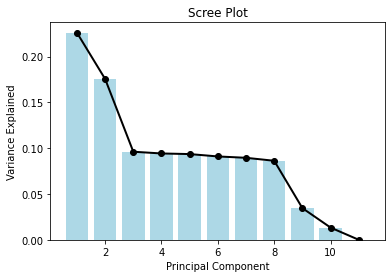

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='black')
plt.bar(PC_values, pca.explained_variance_ratio_, color = 'lightblue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/scree_plot_with_damage.eps', bbox_inches="tight", format='eps')

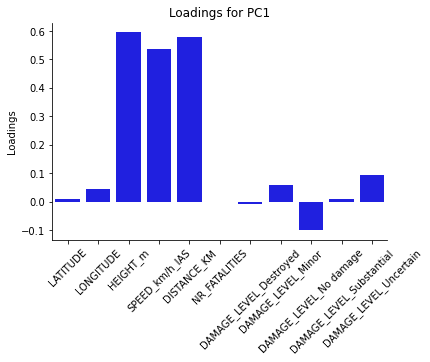

In [ ]:
sns.barplot(x = df_PCA_cont.columns.to_list(),
            y = pca.components_[0],
            color = 'blue')
plt.xticks(rotation = 45)
plt.title('Loadings for PC1')
plt.ylabel('Loadings')
sns.despine()
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/loadings_PC1_with_damage.eps', bbox_inches="tight", format='eps')

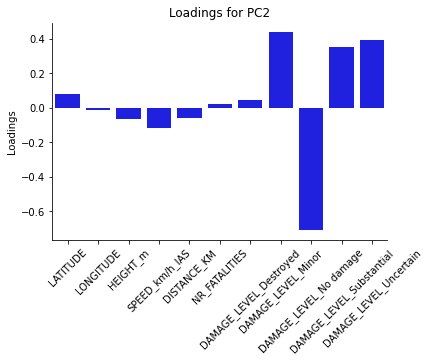

In [ ]:
sns.barplot(x = df_PCA_cont.columns.to_list(),
            y = pca.components_[1],
            color = 'blue')
plt.xticks(rotation = 45)
plt.title('Loadings for PC2')
plt.ylabel('Loadings')
sns.despine()
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/loadings_PC2_with_damage.eps', bbox_inches="tight", format='eps')

In [ ]:
PCA_loadings = {'Variable': df_PCA_cont.columns.to_list(),
                'PC1': pca.components_[0],
                'PC2': pca.components_[1],
                'PC3': pca.components_[2],
                'PC4': pca.components_[3],
                'PC5': pca.components_[4],
                'PC6': pca.components_[5],
                }
PCA_loadings = pd.DataFrame(PCA_loadings)

PCA_contributions = {'Variable': df_PCA_cont.columns.to_list(),
                'Cont_PC1': pca.components_[0]**2,
                'Cont_PC2': pca.components_[1]**2,
                'Cont_PC3': pca.components_[2]**2,
                'Cont_PC4': pca.components_[3]**2,
                'Cont_PC5': pca.components_[4]**2,
                'Cont_PC6': pca.components_[5]**2,
                }
PCA_contributions = pd.DataFrame(PCA_contributions)

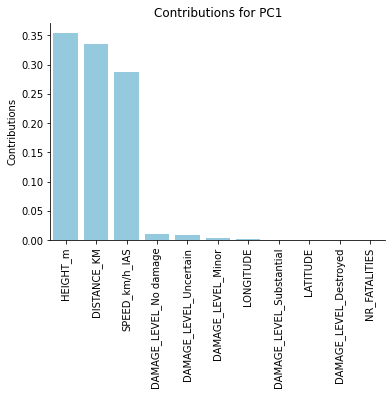

In [ ]:
sns.barplot(x = PCA_contributions.sort_values('Cont_PC1', ascending = False)['Variable'].to_list(),
            y = PCA_contributions.sort_values('Cont_PC1', ascending = False)['Cont_PC1'].values,
            color = 'skyblue')
plt.xticks(rotation = 90)
plt.title('Contributions for PC1')
plt.ylabel('Contributions')
sns.despine()
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/contributions_PC1_with_damage.eps', bbox_inches="tight", format='eps')

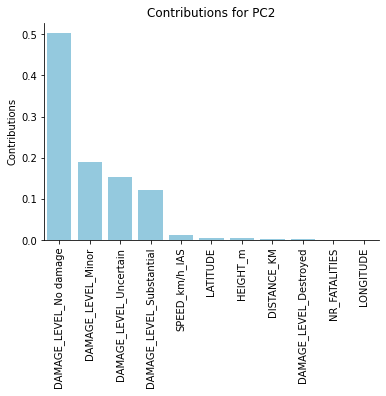

In [ ]:
sns.barplot(x = PCA_contributions.sort_values('Cont_PC2', ascending = False)['Variable'].to_list(),
            y = PCA_contributions.sort_values('Cont_PC2', ascending = False)['Cont_PC2'].values,
            color = 'skyblue')
plt.xticks(rotation = 90)
plt.title('Contributions for PC2')
plt.ylabel('Contributions')
sns.despine()
plt.savefig('/content/gdrive/MyDrive/TFM/plots/PCA/contributions_PC2_with_damage.eps', bbox_inches="tight", format='eps')

In [ ]:
df_PCA_cont['z1'] = x_pca[:, 0]
df_PCA_cont['z2'] = x_pca[:, 1]
df_PCA_cont['DAMAGE_LEVEL'] = df_DAMAGE_LEVEL

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /content/gdrive/MyDrive/TFM/plots/PCA/data_projected_with_damage.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


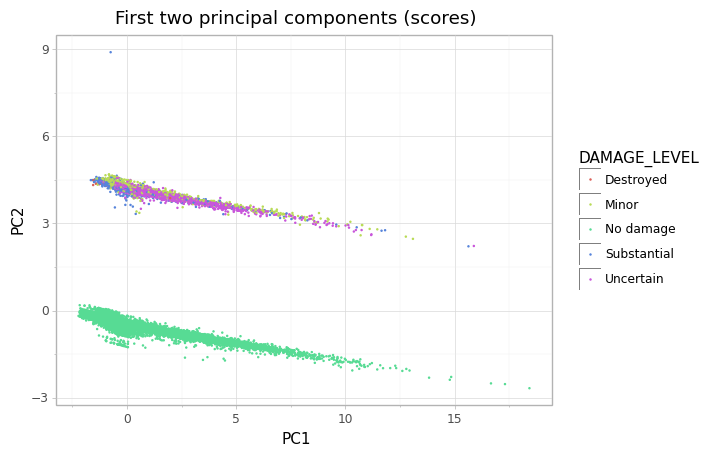

<ggplot: (8741096294581)>

In [ ]:
p = (ggplot(df_PCA_cont, aes(x = 'z1', y = 'z2', color = 'DAMAGE_LEVEL')) +
     geom_point(size=0) +
  labs(title="First two principal components (scores)", x="PC1", y="PC2") + 
  theme_light())
ggsave(plot = p, filename='data_projected_with_damage.png', device = 'png', path = '/content/gdrive/MyDrive/TFM/plots/PCA', ddpi =1000)
p

# MACHINE LEARNING

In [6]:
# dicotomic_variables = ['STR_RAD', 'STR_WINDSHLD', 'STR_NOSE', 'STR_PROP', 'STR_WING_ROT', 'STR_FUSE', 'STR_LG', 'STR_TAIL', 'STR_LGHTS', 'STR_OTHER', 'STR_ENGINE', 'ING_ENGINE']
# variables = ['HEIGHT_m', 'SPEED_km/h_IAS', 'LATITUDE', 'LONGITUDE', 'DISTANCE_KM', 'NR_FATALITIES', 'AC_CLASS', 'INCIDENT_MONTH', 'PHASE_OF_FLIGHT', 'DAMAGE_LEVEL']
dicotomic_variables = ['STR_RAD', 'STR_WINDSHLD', 'STR_NOSE', 'STR_PROP', 'STR_WING_ROT', 'STR_FUSE', 'STR_LG', 'STR_TAIL', 'STR_LGHTS', 'STR_OTHER', 'STR_ENGINE', 'ING_ENGINE']
variables = ['HEIGHT_m', 'SPEED_km/h_IAS', 'LATITUDE', 'LONGITUDE', 'SIZE', 'AC_CLASS', 'INCIDENT_MONTH', 'DAMAGE_LEVEL', 'DISTANCE_KM', 'SKY']
df_corr = df_bird_strikes[dicotomic_variables+variables]

In [7]:
df_corr.shape

(250080, 22)

In [8]:
#df_corr = pd.get_dummies(df_corr, columns=['PHASE_OF_FLIGHT', 'AC_CLASS', 'DAMAGE_LEVEL'])
df_corr = pd.get_dummies(df_corr, columns=['AC_CLASS', 'DAMAGE_LEVEL', 'SIZE', 'SKY', 'INCIDENT_MONTH'])

In [9]:
df_corr.head()

,STR_RAD,STR_WINDSHLD,STR_NOSE,STR_PROP,STR_WING_ROT,STR_FUSE,STR_LG,STR_TAIL,STR_LGHTS,STR_OTHER,STR_ENGINE,ING_ENGINE,HEIGHT_m,SPEED_km/h_IAS,LATITUDE,LONGITUDE,DISTANCE_KM,AC_CLASS_Airplane,AC_CLASS_Glider,AC_CLASS_Helicopter,AC_CLASS_Other,AC_CLASS_Ultralight,DAMAGE_LEVEL_Destroyed,DAMAGE_LEVEL_Minor,DAMAGE_LEVEL_No damage,DAMAGE_LEVEL_Substantial,DAMAGE_LEVEL_Uncertain,SIZE_Large,SIZE_Medium,SIZE_Small,SKY_No Cloud,SKY_Overcast,SKY_Some Cloud,INCIDENT_MONTH_1,INCIDENT_MONTH_2,INCIDENT_MONTH_3,INCIDENT_MONTH_4,INCIDENT_MONTH_5,INCIDENT_MONTH_6,INCIDENT_MONTH_7,INCIDENT_MONTH_8,INCIDENT_MONTH_9,INCIDENT_MONTH_10,INCIDENT_MONTH_11,INCIDENT_MONTH_12
0,False,False,False,False,False,False,False,False,False,False,False,False,60.96,129.64,40.24235,-85.39586,NaN,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,29.99339,-90.25803,0.000,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,41.97960,-87.90446,0.000,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,False,True,False,False,False,False,False,False,False,False,False,False,548.64,277.80,42.93452,-71.43706,14.816,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,False,False,True,False,False,True,False,False,False,False,False,False,60.96,250.02,31.80667,-106.37781,NaN,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


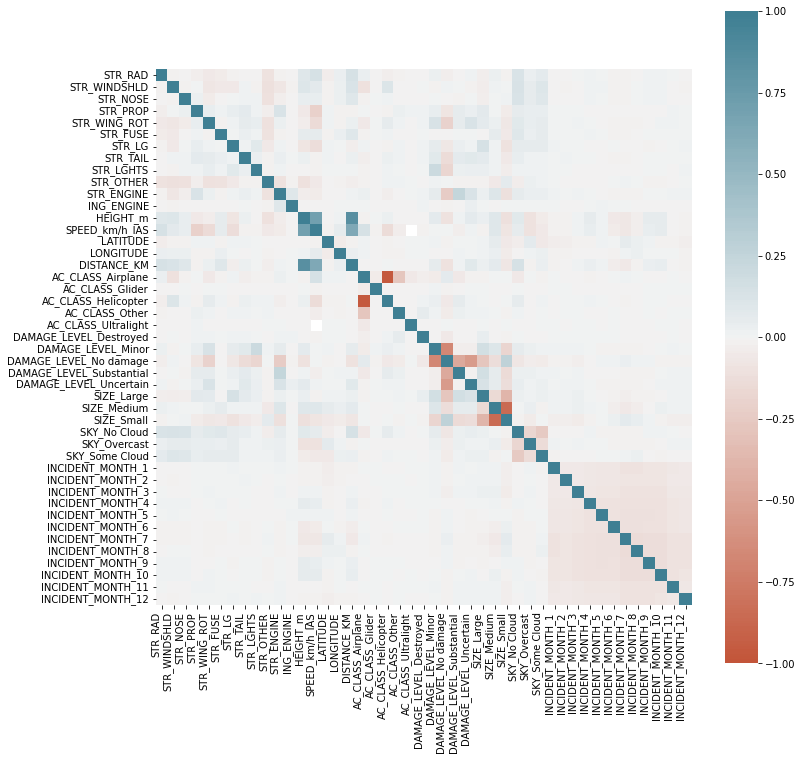

In [10]:
corr = df_corr.corr()
fig = plt.figure(figsize = (12,12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)
plt.show()

In [11]:
round(df_bird_strikes['DAMAGE_LEVEL'].value_counts(normalize = True).sort_values(ascending = False), 4)

No damage      0.9275
Minor          0.0334
Uncertain      0.0224
Substantial    0.0164
Destroyed      0.0003
Name: DAMAGE_LEVEL, dtype: float64

# KNN TO PREDICT DAMAGE LEVEL

In [12]:
df_knn = df_bird_strikes[dicotomic_variables+variables]
df_knn = pd.get_dummies(df_knn, columns=['AC_CLASS', 'SIZE', 'SKY', 'INCIDENT_MONTH'])
df_knn.head()

,STR_RAD,STR_WINDSHLD,STR_NOSE,STR_PROP,STR_WING_ROT,STR_FUSE,STR_LG,STR_TAIL,STR_LGHTS,STR_OTHER,STR_ENGINE,ING_ENGINE,HEIGHT_m,SPEED_km/h_IAS,LATITUDE,LONGITUDE,DAMAGE_LEVEL,DISTANCE_KM,AC_CLASS_Airplane,AC_CLASS_Glider,AC_CLASS_Helicopter,AC_CLASS_Other,AC_CLASS_Ultralight,SIZE_Large,SIZE_Medium,SIZE_Small,SKY_No Cloud,SKY_Overcast,SKY_Some Cloud,INCIDENT_MONTH_1,INCIDENT_MONTH_2,INCIDENT_MONTH_3,INCIDENT_MONTH_4,INCIDENT_MONTH_5,INCIDENT_MONTH_6,INCIDENT_MONTH_7,INCIDENT_MONTH_8,INCIDENT_MONTH_9,INCIDENT_MONTH_10,INCIDENT_MONTH_11,INCIDENT_MONTH_12
0,False,False,False,False,False,False,False,False,False,False,False,False,60.96,129.64,40.24235,-85.39586,No damage,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,29.99339,-90.25803,No damage,0.000,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,41.97960,-87.90446,No damage,0.000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,False,True,False,False,False,False,False,False,False,False,False,False,548.64,277.80,42.93452,-71.43706,Substantial,14.816,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,False,False,True,False,False,True,False,False,False,False,False,False,60.96,250.02,31.80667,-106.37781,No damage,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [13]:
# label_encoder object knows how to understand word labels. 
#label_encoder = preprocessing.LabelEncoder()
# Encode labels for categorical variables
#df_knn['AC_CLASS']= label_encoder.fit_transform(df_knn['AC_CLASS']) 
#df_knn['PHASE_OF_FLIGHT']= label_encoder.fit_transform(df_knn['PHASE_OF_FLIGHT']) 
#df_knn['SIZE']= label_encoder.fit_transform(df_knn['SIZE'])
#df_knn['SKY']= label_encoder.fit_transform(df_knn['SKY']) 
#df_knn['DAMAGE_LEVEL']= label_encoder.fit_transform(df_knn['DAMAGE_LEVEL']) 
#df_knn.head()

In [14]:
#label, category = df_knn['DAMAGE_LEVEL'].value_counts().index.sort_values(), df_bird_strikes['DAMAGE_LEVEL'].value_counts().index.sort_values()
#list(zip(label, category))

In [13]:
damage_level_numbering = {'Uncertain':0 , 'No damage':1, 'Minor':2, 'Substantial':3, 'Destroyed':4}
df_knn['DAMAGE_LEVEL'].replace(damage_level_numbering, inplace = True)
df_knn.head()

,STR_RAD,STR_WINDSHLD,STR_NOSE,STR_PROP,STR_WING_ROT,STR_FUSE,STR_LG,STR_TAIL,STR_LGHTS,STR_OTHER,STR_ENGINE,ING_ENGINE,HEIGHT_m,SPEED_km/h_IAS,LATITUDE,LONGITUDE,DAMAGE_LEVEL,DISTANCE_KM,AC_CLASS_Airplane,AC_CLASS_Glider,AC_CLASS_Helicopter,AC_CLASS_Other,AC_CLASS_Ultralight,SIZE_Large,SIZE_Medium,SIZE_Small,SKY_No Cloud,SKY_Overcast,SKY_Some Cloud,INCIDENT_MONTH_1,INCIDENT_MONTH_2,INCIDENT_MONTH_3,INCIDENT_MONTH_4,INCIDENT_MONTH_5,INCIDENT_MONTH_6,INCIDENT_MONTH_7,INCIDENT_MONTH_8,INCIDENT_MONTH_9,INCIDENT_MONTH_10,INCIDENT_MONTH_11,INCIDENT_MONTH_12
0,False,False,False,False,False,False,False,False,False,False,False,False,60.96,129.64,40.24235,-85.39586,1,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,29.99339,-90.25803,1,0.000,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,41.97960,-87.90446,1,0.000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,False,True,False,False,False,False,False,False,False,False,False,False,548.64,277.80,42.93452,-71.43706,3,14.816,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,False,False,True,False,False,True,False,False,False,False,False,False,60.96,250.02,31.80667,-106.37781,1,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [14]:
df_knn.shape

(250080, 41)

In [15]:
df_knn = df_knn.dropna(inplace = False)
df_knn.shape

(48244, 41)

In [16]:
df_knn['DAMAGE_LEVEL'].value_counts().sort_values(ascending = False)

1    43465
2     1893
0     1643
3     1225
4       18
Name: DAMAGE_LEVEL, dtype: int64

In [17]:
X = df_knn.loc[:, df_knn.columns != 'DAMAGE_LEVEL'].values
y = df_knn.loc[:, df_knn.columns == 'DAMAGE_LEVEL'].values

In [18]:
# Data normalization
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [20]:
# Train and test division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify = y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (38595, 40) (38595, 1)
Test set: (9649, 40) (9649, 1)


In [22]:
#Train Model and Predict  
recall_results = []
accuracy_results = []
for k in range(1, 21):
 cv = StratifiedKFold(n_splits = 5, random_state = 4, shuffle = True)
 neigh = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
 recall = cross_val_score(neigh, X_train, np.ravel(y_train), cv = cv, scoring='recall_macro')
 accuracy = cross_val_score(neigh, X_train, np.ravel(y_train), cv = cv, scoring='accuracy')
 recall_results.append(np.mean(recall))
 accuracy_results.append(np.mean(accuracy))

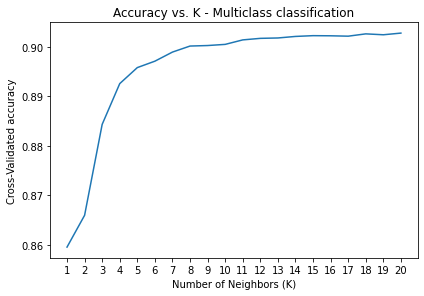

In [23]:
# plot to see clearly
plt.plot(range(1, 21), accuracy_results)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated accuracy')
plt.tight_layout()
plt.xticks(range(1, 21))
plt.title('Accuracy vs. K - Multiclass classification')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/KNN_multi_classif_acc_vs_K.eps', bbox_inches="tight", format='eps')

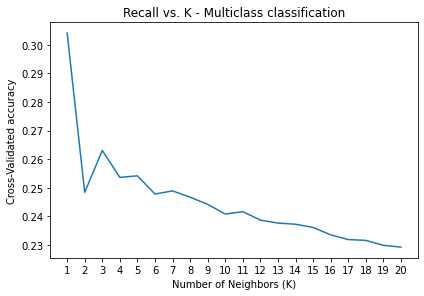

In [24]:
# plot to see clearly
plt.plot(range(1, 21), recall_results)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated accuracy')
plt.tight_layout()
plt.xticks(range(1, 21))
plt.title('Recall vs. K - Multiclass classification')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/KNN_multi_classif_rec_vs_K.eps', bbox_inches="tight", format='eps')

In [21]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1)
#Train the model using the training sets
knn.fit(X_train, np.ravel(y_train))

y_pred = knn.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.23      0.19      0.21       329
           1       0.93      0.97      0.95      8693
           2       0.27      0.11      0.15       379
           3       0.31      0.14      0.19       245
           4       0.00      0.00      0.00         3

    accuracy                           0.89      9649
   macro avg       0.35      0.28      0.30      9649
weighted avg       0.86      0.89      0.87      9649

Confusion matrix, without normalization
[[  62  235   19   13    0]
 [ 117 8451   76   49    0]
 [  48  279   40   12    0]
 [  41  155   15   34    0]
 [   1    2    0    0    0]]


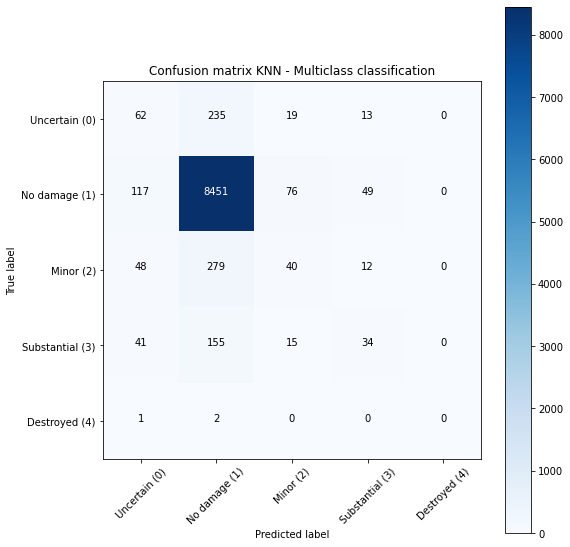

In [22]:
# Compute confusion matrix with 8 neighbours
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes=['Uncertain (0)' , 'No damage (1)', 'Minor (2)', 'Substantial (3)', 'Destroyed (4)'],normalize= False,  title='Confusion matrix KNN - Multiclass classification')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/KNN_multi_classif_conf_matrix.eps', bbox_inches="tight", format='eps')

#### Clasificacion KNN binaria

In [23]:
df_knn_binary = df_bird_strikes[dicotomic_variables+variables]
df_knn_binary = pd.get_dummies(df_knn_binary, columns=['AC_CLASS', 'SIZE', 'SKY', 'INCIDENT_MONTH'])
damage_level_numbering_binary = {'Uncertain':1 , 'No damage':0, 'Minor':1, 'Substantial':1, 'Destroyed':1}
df_knn_binary['DAMAGE_LEVEL'].replace(damage_level_numbering_binary, inplace = True)
df_knn_binary.head()

,STR_RAD,STR_WINDSHLD,STR_NOSE,STR_PROP,STR_WING_ROT,STR_FUSE,STR_LG,STR_TAIL,STR_LGHTS,STR_OTHER,STR_ENGINE,ING_ENGINE,HEIGHT_m,SPEED_km/h_IAS,LATITUDE,LONGITUDE,DAMAGE_LEVEL,DISTANCE_KM,AC_CLASS_Airplane,AC_CLASS_Glider,AC_CLASS_Helicopter,AC_CLASS_Other,AC_CLASS_Ultralight,SIZE_Large,SIZE_Medium,SIZE_Small,SKY_No Cloud,SKY_Overcast,SKY_Some Cloud,INCIDENT_MONTH_1,INCIDENT_MONTH_2,INCIDENT_MONTH_3,INCIDENT_MONTH_4,INCIDENT_MONTH_5,INCIDENT_MONTH_6,INCIDENT_MONTH_7,INCIDENT_MONTH_8,INCIDENT_MONTH_9,INCIDENT_MONTH_10,INCIDENT_MONTH_11,INCIDENT_MONTH_12
0,False,False,False,False,False,False,False,False,False,False,False,False,60.96,129.64,40.24235,-85.39586,0,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,29.99339,-90.25803,0,0.000,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,41.97960,-87.90446,0,0.000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,False,True,False,False,False,False,False,False,False,False,False,False,548.64,277.80,42.93452,-71.43706,1,14.816,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,False,False,True,False,False,True,False,False,False,False,False,False,60.96,250.02,31.80667,-106.37781,0,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [24]:
df_knn_binary['DAMAGE_LEVEL'].value_counts()

0    231938
1     18142
Name: DAMAGE_LEVEL, dtype: int64

In [25]:
df_knn_binary = df_knn_binary.dropna(inplace = False)
df_knn_binary.shape
X = df_knn_binary.loc[:, df_knn_binary.columns != 'DAMAGE_LEVEL'].values
y = df_knn_binary.loc[:, df_knn_binary.columns == 'DAMAGE_LEVEL'].values

In [26]:
# Data normalization
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [27]:
# Train and test division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify = y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (38595, 40) (38595, 1)
Test set: (9649, 40) (9649, 1)


In [28]:
#Train Model and Predict  
recall_results = []
accuracy_results = []
for k in range(1, 20):
 cv = StratifiedKFold(n_splits = 5, random_state = 4, shuffle = True)
 neigh = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
 recall = cross_val_score(neigh, X_train, np.ravel(y_train), cv = cv, scoring='recall')
 accuracy = cross_val_score(neigh, X_train, np.ravel(y_train), cv = cv, scoring='accuracy')
 recall_results.append(np.mean(recall))
 accuracy_results.append(np.mean(accuracy))


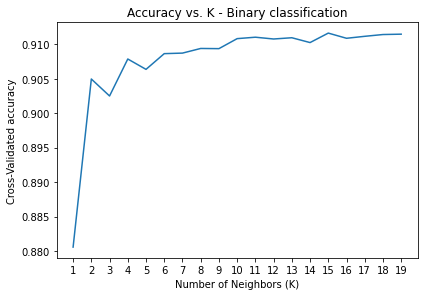

In [29]:
# plot to see clearly
plt.plot(range(1, 20), accuracy_results)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated accuracy')
plt.tight_layout()
plt.xticks(range(1, 20))
plt.title('Accuracy vs. K - Binary classification')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/KNN_binary_classif_acc_vs_K.eps', bbox_inches="tight", format='eps')

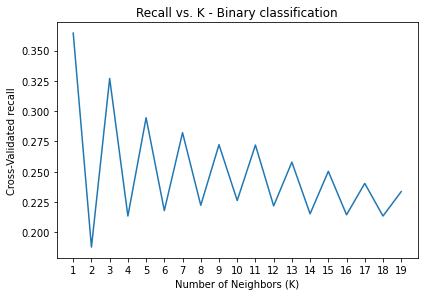

In [30]:
# plot to see clearly
plt.plot(range(1, 20), recall_results)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated recall')
plt.tight_layout()
plt.xticks(range(1, 20))
plt.title('Recall vs. K - Binary classification')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/KNN_binary_classif_rec_vs_K.eps', bbox_inches="tight", format='eps')

In [35]:
#Train Model and Predict
knn = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1).fit(X_train, np.ravel(y_train))
y_pred = knn.predict(X_test)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      8693
           1       0.50      0.33      0.40       956

    accuracy                           0.90      9649
   macro avg       0.72      0.65      0.67      9649
weighted avg       0.89      0.90      0.89      9649

Confusion matrix, without normalization
[[8385  308]
 [ 643  313]]


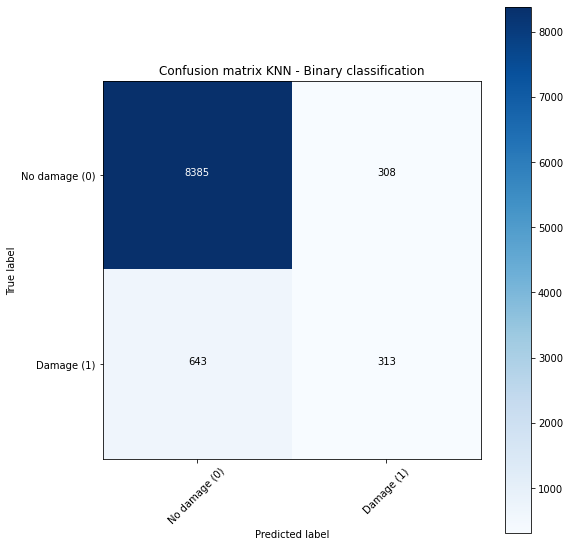

In [37]:
# Compute confusion matrix with 3 neighbours
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes=['No damage (0)', 'Damage (1)'],normalize= False,  title='Confusion matrix KNN - Binary classification')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/KNN_binary_classif_conf_matrix.eps', bbox_inches="tight", format='eps')

# RANDOM FOREST TO PREDICT DAMAGE LEVEL

### Random Forest With Grid Search - Multiclass classification

In [ ]:
df_rf = df_bird_strikes[dicotomic_variables+variables]
df_rf = pd.get_dummies(df_rf, columns=['AC_CLASS', 'SIZE', 'SKY', 'INCIDENT_MONTH'])

In [ ]:
damage_level_numbering = {'Uncertain':0 , 'No damage':1, 'Minor':2, 'Substantial':3, 'Destroyed':4}
df_rf['DAMAGE_LEVEL'].replace(damage_level_numbering, inplace = True)
df_rf.head()

,STR_RAD,STR_WINDSHLD,STR_NOSE,STR_PROP,STR_WING_ROT,STR_FUSE,STR_LG,STR_TAIL,STR_LGHTS,STR_OTHER,STR_ENGINE,ING_ENGINE,HEIGHT_m,SPEED_km/h_IAS,LATITUDE,LONGITUDE,DAMAGE_LEVEL,DISTANCE_KM,AC_CLASS_Airplane,AC_CLASS_Glider,AC_CLASS_Helicopter,AC_CLASS_Other,AC_CLASS_Ultralight,SIZE_Large,SIZE_Medium,SIZE_Small,SKY_No Cloud,SKY_Overcast,SKY_Some Cloud,INCIDENT_MONTH_1,INCIDENT_MONTH_2,INCIDENT_MONTH_3,INCIDENT_MONTH_4,INCIDENT_MONTH_5,INCIDENT_MONTH_6,INCIDENT_MONTH_7,INCIDENT_MONTH_8,INCIDENT_MONTH_9,INCIDENT_MONTH_10,INCIDENT_MONTH_11,INCIDENT_MONTH_12
0,False,False,False,False,False,False,False,False,False,False,False,False,60.96,129.64,40.24235,-85.39586,1,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,29.99339,-90.25803,1,0.000,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,41.97960,-87.90446,1,0.000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,False,True,False,False,False,False,False,False,False,False,False,False,548.64,277.80,42.93452,-71.43706,3,14.816,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,False,False,True,False,False,True,False,False,False,False,False,False,60.96,250.02,31.80667,-106.37781,1,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
df_rf = df_rf.dropna(inplace = False)
df_rf.shape

(48244, 41)

In [ ]:
df_rf['DAMAGE_LEVEL'].value_counts().sort_values(ascending = False)

1    43465
2     1893
0     1643
3     1225
4       18
Name: DAMAGE_LEVEL, dtype: int64

In [ ]:
X = df_rf.loc[:, df_rf.columns != 'DAMAGE_LEVEL'].values
y = df_rf.loc[:, df_rf.columns == 'DAMAGE_LEVEL'].values

In [ ]:
features = [col for col in df_rf.loc[:, df_rf.columns != 'DAMAGE_LEVEL']]

In [ ]:
# Data normalization
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [ ]:
# Train and test division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (38595, 40) (38595, 1)
Test set: (9649, 40) (9649, 1)


In [ ]:
# Grid search definition
n_estimators = [100, 200, 300]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)
clf = RandomForestClassifier(random_state = 42)
gridF = GridSearchCV(clf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestFit = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
gridF.best_params_

{'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}

In [ ]:
yhat = bestFit.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, yhat))

Accuracy: 0.9036169551248834


In [ ]:
# random forest model creation with the best parameters
rfc = RandomForestClassifier(max_depth=30, min_samples_split=10, min_samples_leaf=2, n_estimators=200, random_state = 42)
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)
#clf = RandomForestClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=2, n_estimators=200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
scores = cross_val_score(rfc, X, np.ravel(y), cv=5)
print('Scores =', scores)
fold_number = np.arange(1, len(scores) +1)

KeyboardInterrupt: ignored

In [ ]:
feature_imp = pd.Series(rfc.feature_importances_, features).sort_values(ascending=False)
feature_imp.head()

SIZE_Large        0.100577
LATITUDE          0.091095
LONGITUDE         0.090474
SPEED_km/h_IAS    0.087346
STR_ENGINE        0.085291
dtype: float64

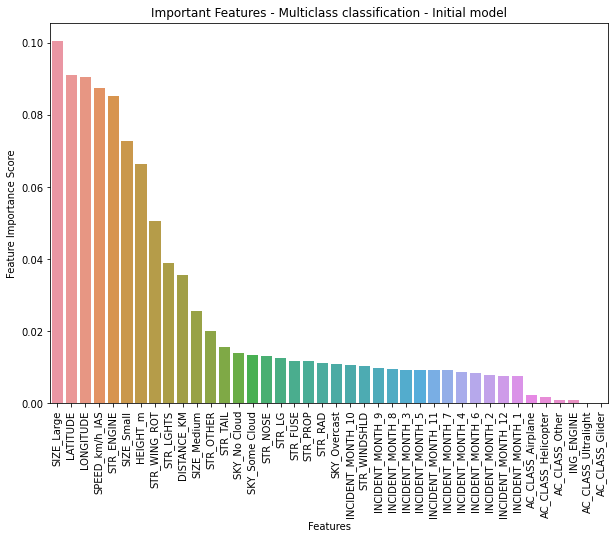

In [ ]:
plt.figure(figsize = (10, 7))
sns.barplot(x=feature_imp.index, y=feature_imp)
# Add labels to your graph
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title("Important Features - Multiclass classification - Initial model")
plt.xticks(rotation=90)
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/RF_multi_classif_important_features_initial_model.eps', bbox_inches="tight", format='eps')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.33      0.06      0.11       329
           1       0.92      0.99      0.95      8693
           2       0.39      0.08      0.13       379
           3       0.38      0.11      0.18       245
           4       0.00      0.00      0.00         3

    accuracy                           0.90      9649
   macro avg       0.40      0.25      0.27      9649
weighted avg       0.86      0.90      0.87      9649

Confusion matrix, without normalization
[[  21  282   15   11    0]
 [  10 8641   21   21    0]
 [  16  322   29   12    0]
 [  17  190   10   28    0]
 [   0    1    0    2    0]]


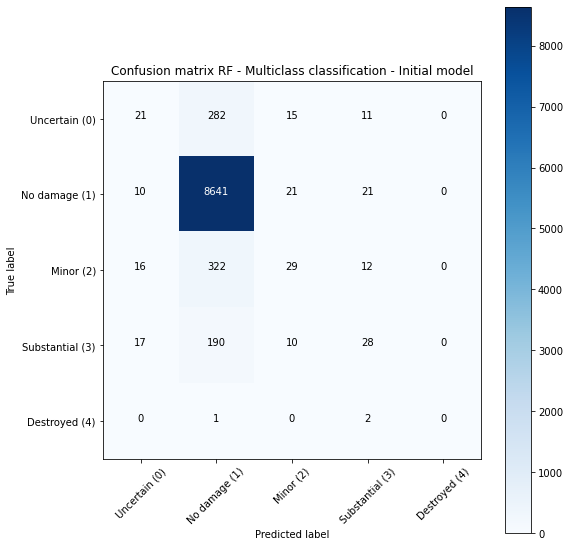

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rfc_predict, labels=[0,1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, rfc_predict))

# Plot non-normalized confusion matrix
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes=['Uncertain (0)' , 'No damage (1)', 'Minor (2)', 'Substantial (3)', 'Destroyed (4)'] ,normalize= False,  title='Confusion matrix RF - Multiclass classification - Initial model')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/RF_multi_classif_conf_matrix_initial_model.eps', bbox_inches="tight", format='eps')

### Random Forest With Grid Search - Multiclass classification WEIGHTED

In [ ]:
df_rf = df_bird_strikes[dicotomic_variables+variables]
df_rf = pd.get_dummies(df_rf, columns=['AC_CLASS', 'SIZE', 'SKY', 'INCIDENT_MONTH'])

In [ ]:
damage_level_numbering = {'Uncertain':0 , 'No damage':1, 'Minor':2, 'Substantial':3, 'Destroyed':4}
df_rf['DAMAGE_LEVEL'].replace(damage_level_numbering, inplace = True)
df_rf.head()

,STR_RAD,STR_WINDSHLD,STR_NOSE,STR_PROP,STR_WING_ROT,STR_FUSE,STR_LG,STR_TAIL,STR_LGHTS,STR_OTHER,STR_ENGINE,ING_ENGINE,HEIGHT_m,SPEED_km/h_IAS,LATITUDE,LONGITUDE,DAMAGE_LEVEL,DISTANCE_KM,AC_CLASS_Airplane,AC_CLASS_Glider,AC_CLASS_Helicopter,AC_CLASS_Other,AC_CLASS_Ultralight,SIZE_Large,SIZE_Medium,SIZE_Small,SKY_No Cloud,SKY_Overcast,SKY_Some Cloud,INCIDENT_MONTH_1,INCIDENT_MONTH_2,INCIDENT_MONTH_3,INCIDENT_MONTH_4,INCIDENT_MONTH_5,INCIDENT_MONTH_6,INCIDENT_MONTH_7,INCIDENT_MONTH_8,INCIDENT_MONTH_9,INCIDENT_MONTH_10,INCIDENT_MONTH_11,INCIDENT_MONTH_12
0,False,False,False,False,False,False,False,False,False,False,False,False,60.96,129.64,40.24235,-85.39586,1,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,29.99339,-90.25803,1,0.000,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,41.97960,-87.90446,1,0.000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,False,True,False,False,False,False,False,False,False,False,False,False,548.64,277.80,42.93452,-71.43706,3,14.816,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,False,False,True,False,False,True,False,False,False,False,False,False,60.96,250.02,31.80667,-106.37781,1,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
df_rf = df_rf.dropna(inplace = False)
df_rf.shape

(48244, 41)

In [ ]:
df_rf['DAMAGE_LEVEL'].value_counts().sort_values(ascending = False)

1    43465
2     1893
0     1643
3     1225
4       18
Name: DAMAGE_LEVEL, dtype: int64

In [ ]:
X = df_rf.loc[:, df_rf.columns != 'DAMAGE_LEVEL'].values
y = df_rf.loc[:, df_rf.columns == 'DAMAGE_LEVEL'].values

In [ ]:
features = [col for col in df_rf.loc[:, df_rf.columns != 'DAMAGE_LEVEL']]

In [ ]:
# Data normalization
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [ ]:
# Train and test division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (38595, 40) (38595, 1)
Test set: (9649, 40) (9649, 1)


In [ ]:
# Grid search definition
n_estimators = [100, 200, 300]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)
clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced')
gridF = GridSearchCV(clf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestFit = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
gridF.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
yhat = gridF.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, yhat))

Accuracy: 0.9016478391543165


In [ ]:
# random forest model creation with the best parameters
rfc = RandomForestClassifier(max_depth=30, min_samples_split=2, min_samples_leaf=1, n_estimators=300, class_weight = 'balanced', random_state = 42)
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)
#clf = RandomForestClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=2, n_estimators=200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
scores = cross_val_score(rfc, X, np.ravel(y), cv=5)
print('Scores =', scores)
fold_number = np.arange(1, len(scores) +1)

KeyboardInterrupt: ignored

In [ ]:
feature_imp = pd.Series(rfc.feature_importances_, features).sort_values(ascending=False)
feature_imp.head()

LATITUDE          0.133797
SPEED_km/h_IAS    0.123235
LONGITUDE         0.117965
HEIGHT_m          0.072555
STR_ENGINE        0.066639
dtype: float64

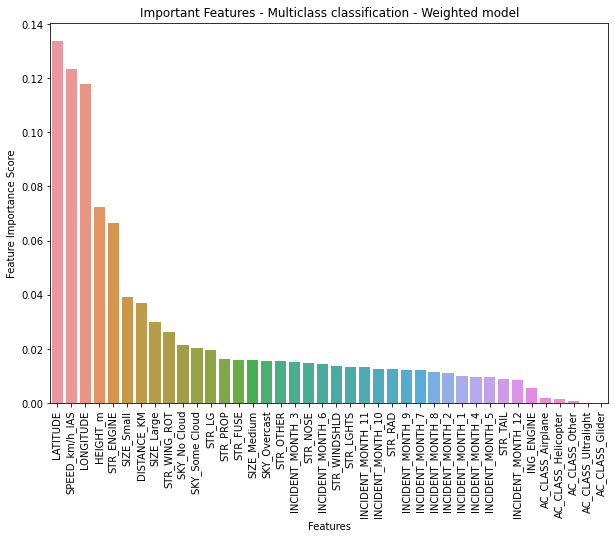

In [ ]:
plt.figure(figsize = (10, 7))
sns.barplot(x=feature_imp.index, y=feature_imp)
# Add labels to your graph
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title("Important Features - Multiclass classification - Weighted model")
plt.xticks(rotation=90)
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/RF_multi_classif_important_features_weighted.eps', bbox_inches="tight", format='eps')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.29      0.05      0.08       329
           1       0.91      0.99      0.95      8693
           2       0.33      0.04      0.07       379
           3       0.36      0.10      0.15       245
           4       0.00      0.00      0.00         3

    accuracy                           0.90      9649
   macro avg       0.38      0.24      0.25      9649
weighted avg       0.85      0.90      0.87      9649

Confusion matrix, without normalization
[[  16  296    8    9    0]
 [  10 8645   16   22    0]
 [  15  339   15   10    0]
 [  14  201    6   24    0]
 [   0    1    0    2    0]]


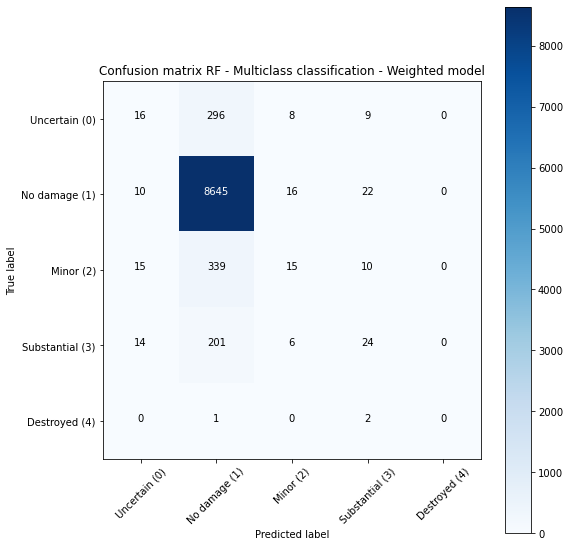

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rfc_predict, labels=[0,1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, rfc_predict))

# Plot non-normalized confusion matrix
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes=['Uncertain (0)' , 'No damage (1)', 'Minor (2)', 'Substantial (3)', 'Destroyed (4)'] ,normalize= False,  title='Confusion matrix RF - Multiclass classification - Weighted model')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/RF_multi_classif_conf_matrix_weighted.eps', bbox_inches="tight", format='eps')

### Random Forest With Grid Search - Binary classification WEIGHTED

In [ ]:
df_rf_binary = df_bird_strikes[dicotomic_variables+variables]
df_rf_binary = pd.get_dummies(df_rf_binary, columns=['AC_CLASS', 'SIZE', 'SKY', 'INCIDENT_MONTH'])
damage_level_numbering_binary = {'Uncertain':1 , 'No damage':0, 'Minor':1, 'Substantial':1, 'Destroyed':1}
df_rf_binary['DAMAGE_LEVEL'].replace(damage_level_numbering_binary, inplace = True)
df_rf_binary.head()

,STR_RAD,STR_WINDSHLD,STR_NOSE,STR_PROP,STR_WING_ROT,STR_FUSE,STR_LG,STR_TAIL,STR_LGHTS,STR_OTHER,STR_ENGINE,ING_ENGINE,HEIGHT_m,SPEED_km/h_IAS,LATITUDE,LONGITUDE,DAMAGE_LEVEL,DISTANCE_KM,AC_CLASS_Airplane,AC_CLASS_Glider,AC_CLASS_Helicopter,AC_CLASS_Other,AC_CLASS_Ultralight,SIZE_Large,SIZE_Medium,SIZE_Small,SKY_No Cloud,SKY_Overcast,SKY_Some Cloud,INCIDENT_MONTH_1,INCIDENT_MONTH_2,INCIDENT_MONTH_3,INCIDENT_MONTH_4,INCIDENT_MONTH_5,INCIDENT_MONTH_6,INCIDENT_MONTH_7,INCIDENT_MONTH_8,INCIDENT_MONTH_9,INCIDENT_MONTH_10,INCIDENT_MONTH_11,INCIDENT_MONTH_12
0,False,False,False,False,False,False,False,False,False,False,False,False,60.96,129.64,40.24235,-85.39586,0,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,29.99339,-90.25803,0,0.000,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,41.97960,-87.90446,0,0.000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,False,True,False,False,False,False,False,False,False,False,False,False,548.64,277.80,42.93452,-71.43706,1,14.816,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,False,False,True,False,False,True,False,False,False,False,False,False,60.96,250.02,31.80667,-106.37781,0,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
round(df_rf_binary['DAMAGE_LEVEL'].value_counts(normalize = True), 4)

0    0.9275
1    0.0725
Name: DAMAGE_LEVEL, dtype: float64

In [ ]:
df_rf_binary = df_rf_binary.dropna(inplace = False)
X = df_rf_binary.loc[:, df_rf.columns != 'DAMAGE_LEVEL'].values
y = df_rf_binary.loc[:, df_rf.columns == 'DAMAGE_LEVEL'].values

In [ ]:
features = [col for col in df_rf_binary.loc[:, df_rf_binary.columns != 'DAMAGE_LEVEL']]

In [ ]:
# Data normalization
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [ ]:
# Train and test division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (38595, 40) (38595, 1)
Test set: (9649, 40) (9649, 1)


In [ ]:
# Grid search definition
n_estimators = [100, 200, 300]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10] 

hyperF_binary = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)
clf_binary = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
gridF_binary = GridSearchCV(clf_binary, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestFit_binary = gridF_binary.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
bestFit_binary

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 8, 15, 25, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15, 20],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [ ]:
gridF_binary.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 300}

In [ ]:
yhat = bestFit_binary.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, yhat))

In [ ]:
# random forest model creation with the best parameters
rfc_binary = RandomForestClassifier(max_depth=30, min_samples_split=5, min_samples_leaf=1, n_estimators=300, class_weight = 'balanced', random_state = 42)
rfc_binary.fit(X_train,y_train)
# predictions
rfc_binary_predict = rfc_binary.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
scores_binary = cross_val_score(rfc_binary, X, np.ravel(y), cv=5)
print('Scores =', scores)
fold_number = np.arange(1, len(scores) +1)

In [ ]:
sns.scatterplot(x = fold_number,
                y = scores_binary,
                color = 'black')
sns.lineplot(x = fold_number,
                y = scores,
                color = 'black')
plt.ylim(0, 1.0)
plt.grid()
plt.xlabel('Fold number')
plt.ylabel('Accuracy')
plt.title('K-fold Cross validation')

In [ ]:
feature_imp_binary = pd.Series(rfc_binary.feature_importances_, features).sort_values(ascending=False)
feature_imp_binary.head()

SIZE_Small    0.131027
STR_ENGINE    0.102022
LATITUDE      0.089182
LONGITUDE     0.086659
SIZE_Large    0.083292
dtype: float64

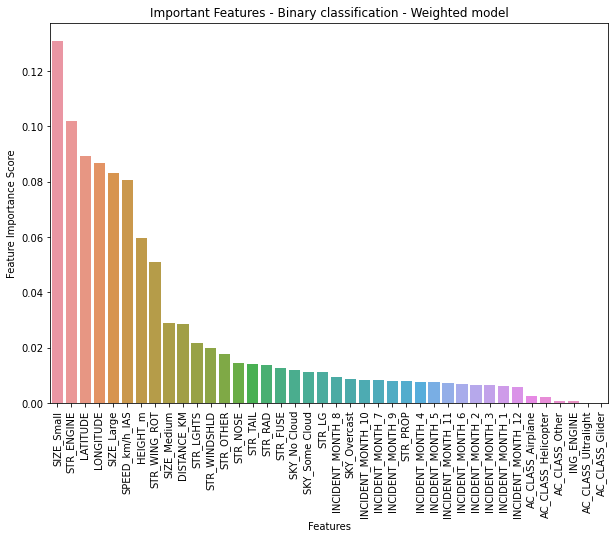

In [ ]:
plt.figure(figsize = (10, 7))
sns.barplot(x=feature_imp_binary.index, y=feature_imp_binary)
# Add labels to your graph
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title("Important Features - Binary classification - Weighted model")
plt.xticks(rotation=90)
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/RF_binary_classif_important_features_weighted.eps', bbox_inches="tight", format='eps')

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      8693
           1       0.60      0.48      0.53       956

    accuracy                           0.92      9649
   macro avg       0.77      0.72      0.74      9649
weighted avg       0.91      0.92      0.91      9649

Confusion matrix, without normalization
[[8392  301]
 [ 500  456]]


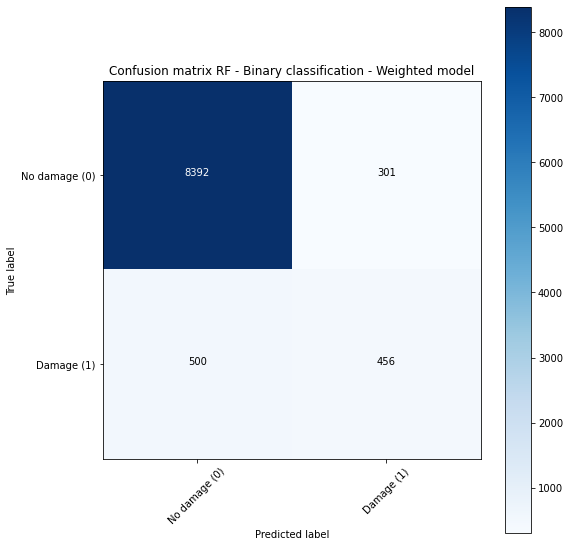

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rfc_binary_predict, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, rfc_binary_predict))

# Plot non-normalized confusion matrix
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes=['No damage (0)', 'Damage (1)'] ,normalize= False,  title='Confusion matrix RF - Binary classification - Weighted model')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/RF_binary_classif_conf_matrix_weighted.eps', bbox_inches="tight", format='eps')

### Random Forest With Grid Search - Binary classification OVERSAMPLED

In [ ]:
df_rf_binary = df_bird_strikes[dicotomic_variables+variables]
df_rf_binary = pd.get_dummies(df_rf_binary, columns=['AC_CLASS', 'SIZE', 'SKY', 'INCIDENT_MONTH'])
damage_level_numbering_binary = {'Uncertain':1 , 'No damage':0, 'Minor':1, 'Substantial':1, 'Destroyed':1}
df_rf_binary['DAMAGE_LEVEL'].replace(damage_level_numbering_binary, inplace = True)
df_rf_binary.head()

,STR_RAD,STR_WINDSHLD,STR_NOSE,STR_PROP,STR_WING_ROT,STR_FUSE,STR_LG,STR_TAIL,STR_LGHTS,STR_OTHER,STR_ENGINE,ING_ENGINE,HEIGHT_m,SPEED_km/h_IAS,LATITUDE,LONGITUDE,DAMAGE_LEVEL,DISTANCE_KM,AC_CLASS_Airplane,AC_CLASS_Glider,AC_CLASS_Helicopter,AC_CLASS_Other,AC_CLASS_Ultralight,SIZE_Large,SIZE_Medium,SIZE_Small,SKY_No Cloud,SKY_Overcast,SKY_Some Cloud,INCIDENT_MONTH_1,INCIDENT_MONTH_2,INCIDENT_MONTH_3,INCIDENT_MONTH_4,INCIDENT_MONTH_5,INCIDENT_MONTH_6,INCIDENT_MONTH_7,INCIDENT_MONTH_8,INCIDENT_MONTH_9,INCIDENT_MONTH_10,INCIDENT_MONTH_11,INCIDENT_MONTH_12
0,False,False,False,False,False,False,False,False,False,False,False,False,60.96,129.64,40.24235,-85.39586,0,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,29.99339,-90.25803,0,0.000,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,41.97960,-87.90446,0,0.000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,False,True,False,False,False,False,False,False,False,False,False,False,548.64,277.80,42.93452,-71.43706,1,14.816,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,False,False,True,False,False,True,False,False,False,False,False,False,60.96,250.02,31.80667,-106.37781,0,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
df_rf_binary = df_rf_binary.dropna(inplace = False)
X = df_rf_binary.loc[:, df_rf_binary.columns != 'DAMAGE_LEVEL'].values
y = df_rf_binary.loc[:, df_rf_binary.columns == 'DAMAGE_LEVEL'].values

In [ ]:
features = [col for col in df_rf_binary.loc[:, df_rf_binary.columns != 'DAMAGE_LEVEL']]

In [ ]:
df_rf_binary['DAMAGE_LEVEL'].value_counts(normalize = True)

0    0.900941
1    0.099059
Name: DAMAGE_LEVEL, dtype: float64

In [ ]:
# Train and test division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (38595, 40) (38595, 1)
Test set: (9649, 40) (9649, 1)


In [ ]:
pd.DataFrame(data = y_test).value_counts(normalize = True)

0    0.900922
1    0.099078
dtype: float64

In [ ]:
# instantiating the random over sampler 
ros = RandomOverSampler(random_state = 4, sampling_strategy=0.4)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
print(Counter(y_train_resampled))
print ('Train set resampled:', X_train_resampled.shape,  y_train_resampled.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Counter({0: 34772, 1: 13908})
Train set resampled: (48680, 40) (48680,)
Test set: (9649, 40) (9649, 1)


In [ ]:
pd.DataFrame(data = y_train_resampled).value_counts(normalize = True)

0    0.714297
1    0.285703
dtype: float64

In [ ]:
# Data normalization
X_train_resampled = preprocessing.StandardScaler().fit(X_train_resampled).transform(X_train_resampled.astype(float))
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

In [ ]:
# Grid search definition
n_estimators = [275, 300, 325, 350]
max_depth = [28, 30, 32, 34]
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 5, 10] 

hyperF_binary_resampled = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)
clf_binary_resampled = RandomForestClassifier(random_state = 42)
gridF_binary_resampled = GridSearchCV(clf_binary_resampled, hyperF_binary_resampled, cv = 5, verbose = 1, 
                      n_jobs = -1)
bestFit_binary_resampled = gridF_binary_resampled.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


In [ ]:
bestFit_binary_resampled.best_params_

{'max_depth': 34,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
# random forest model creation with the best parameters for the resampled fit
rfc_binary = RandomForestClassifier(max_depth=34, min_samples_split=2, min_samples_leaf=1, n_estimators=300, random_state = 42)
rfc_binary.fit(X_train_resampled, y_train_resampled)
# predictions
rfc_binary_predict = rfc_binary.predict(X_test)

In [ ]:
scores_binary = cross_val_score(rfc_binary, X, np.ravel(y), cv=5)
print('Scores =', scores_binary)
fold_number = np.arange(1, len(scores_binary) +1)

In [ ]:
feature_imp_binary = pd.Series(rfc_binary.feature_importances_, features).sort_values(ascending=False)
feature_imp_binary.head()

LATITUDE          0.103594
LONGITUDE         0.102119
SIZE_Small        0.094835
SPEED_km/h_IAS    0.092853
SIZE_Large        0.092722
dtype: float64

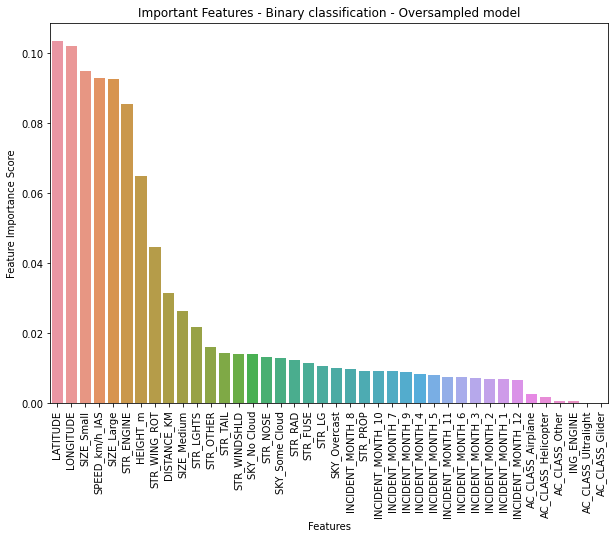

In [ ]:
plt.figure(figsize = (10, 7))
sns.barplot(x=feature_imp_binary.index, y=feature_imp_binary)
# Add labels to your graph
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title("Important Features - Binary classification - Oversampled model")
plt.xticks(rotation=90)
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/RF_binary_classif_important_features_oversampled.eps', bbox_inches="tight", format='eps')

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      8693
           1       0.59      0.46      0.52       956

    accuracy                           0.92      9649
   macro avg       0.77      0.71      0.74      9649
weighted avg       0.91      0.92      0.91      9649

Confusion matrix, without normalization
[[8390  303]
 [ 516  440]]


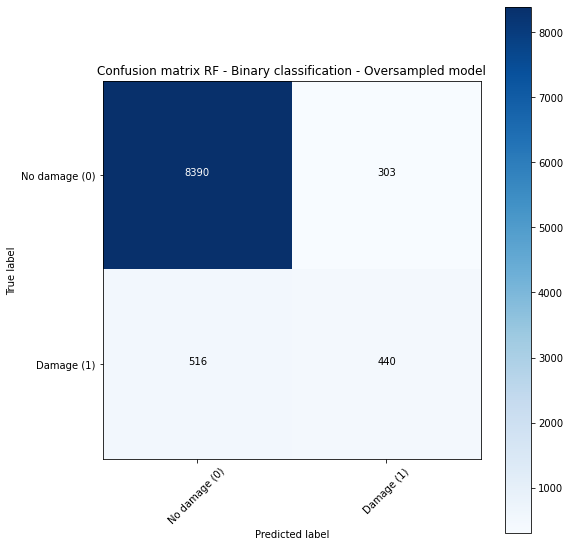

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rfc_binary_predict, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, rfc_binary_predict))

# Plot non-normalized confusion matrix
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes=['No damage (0)', 'Damage (1)'] ,normalize= False,  title='Confusion matrix RF - Binary classification - Oversampled model')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/RF_binary_classif_conf_matrix_oversampled.eps', bbox_inches="tight", format='eps')

### Random Forest With Grid Search - Binary classification UNDERSAMPLED

In [ ]:
df_rf_binary = df_bird_strikes[dicotomic_variables+variables]
df_rf_binary = pd.get_dummies(df_rf_binary, columns=['AC_CLASS', 'SIZE', 'SKY', 'INCIDENT_MONTH'])
damage_level_numbering_binary = {'Uncertain':1 , 'No damage':0, 'Minor':1, 'Substantial':1, 'Destroyed':1}
df_rf_binary['DAMAGE_LEVEL'].replace(damage_level_numbering_binary, inplace = True)
df_rf_binary.head()

,STR_RAD,STR_WINDSHLD,STR_NOSE,STR_PROP,STR_WING_ROT,STR_FUSE,STR_LG,STR_TAIL,STR_LGHTS,STR_OTHER,STR_ENGINE,ING_ENGINE,HEIGHT_m,SPEED_km/h_IAS,LATITUDE,LONGITUDE,DAMAGE_LEVEL,DISTANCE_KM,AC_CLASS_Airplane,AC_CLASS_Glider,AC_CLASS_Helicopter,AC_CLASS_Other,AC_CLASS_Ultralight,SIZE_Large,SIZE_Medium,SIZE_Small,SKY_No Cloud,SKY_Overcast,SKY_Some Cloud,INCIDENT_MONTH_1,INCIDENT_MONTH_2,INCIDENT_MONTH_3,INCIDENT_MONTH_4,INCIDENT_MONTH_5,INCIDENT_MONTH_6,INCIDENT_MONTH_7,INCIDENT_MONTH_8,INCIDENT_MONTH_9,INCIDENT_MONTH_10,INCIDENT_MONTH_11,INCIDENT_MONTH_12
0,False,False,False,False,False,False,False,False,False,False,False,False,60.96,129.64,40.24235,-85.39586,0,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,29.99339,-90.25803,0,0.000,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,True,False,False,False,False,False,False,False,False,False,False,False,0.00,NaN,41.97960,-87.90446,0,0.000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,False,True,False,False,False,False,False,False,False,False,False,False,548.64,277.80,42.93452,-71.43706,1,14.816,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,False,False,True,False,False,True,False,False,False,False,False,False,60.96,250.02,31.80667,-106.37781,0,NaN,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
df_rf_binary.shape

(250080, 41)

In [ ]:
df_rf_binary = df_rf_binary.dropna(inplace = False)
X = df_rf_binary.loc[:, df_rf_binary.columns != 'DAMAGE_LEVEL'].values
y = df_rf_binary.loc[:, df_rf_binary.columns == 'DAMAGE_LEVEL'].values

In [ ]:
features = [col for col in df_rf_binary.loc[:, df_rf_binary.columns != 'DAMAGE_LEVEL']]

In [ ]:
df_rf_binary['DAMAGE_LEVEL'].value_counts(normalize = True)

0    0.900941
1    0.099059
Name: DAMAGE_LEVEL, dtype: float64

In [ ]:
# Train and test division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (38595, 40) (38595, 1)
Test set: (9649, 40) (9649, 1)


In [ ]:
pd.DataFrame(data = y_test).value_counts(normalize = True)

0    0.900922
1    0.099078
dtype: float64

In [ ]:
# instantiating the random over sampler 
ros = RandomUnderSampler(random_state = 4, sampling_strategy=0.4)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
print(Counter(y_train_resampled))
print ('Train set resampled:', X_train_resampled.shape,  y_train_resampled.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Counter({0: 9557, 1: 3823})
Train set resampled: (13380, 40) (13380,)
Test set: (9649, 40) (9649, 1)


In [ ]:
pd.DataFrame(data = y_train_resampled).value_counts(normalize = True)

0    0.714275
1    0.285725
dtype: float64

In [ ]:
# Data normalization
X_train_resampled = preprocessing.StandardScaler().fit(X_train_resampled).transform(X_train_resampled.astype(float))
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

In [ ]:
# Grid search definition
n_estimators = [275, 300, 325, 350]
max_depth = [28, 30, 32, 34]
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 5, 10] 

hyperF_binary_resampled = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)
clf_binary_resampled = RandomForestClassifier(random_state = 42)
gridF_binary_resampled = GridSearchCV(clf_binary_resampled, hyperF_binary_resampled, cv = 5, verbose = 1, 
                      n_jobs = -1)
bestFit_binary_resampled = gridF_binary_resampled.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


In [ ]:
bestFit_binary_resampled.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 325}

In [ ]:
# random forest model creation with the best parameters for the resampled fit
rfc_binary = RandomForestClassifier(max_depth=30, min_samples_split=3, min_samples_leaf=1, n_estimators=325, random_state = 42)
rfc_binary.fit(X_train_resampled, y_train_resampled)
# predictions
rfc_binary_predict = rfc_binary.predict(X_test)

In [ ]:
feature_imp_binary = pd.Series(rfc_binary.feature_importances_, features).sort_values(ascending=False)
feature_imp_binary.head()

SIZE_Small    0.103188
SIZE_Large    0.096183
STR_ENGINE    0.095176
LATITUDE      0.094684
LONGITUDE     0.091931
dtype: float64

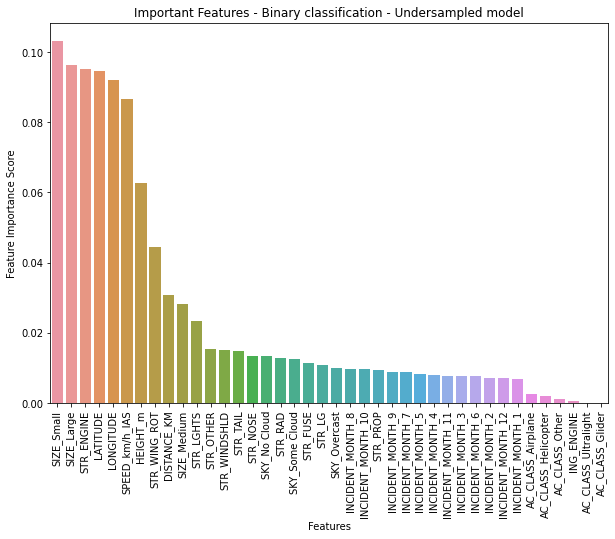

In [ ]:
plt.figure(figsize = (10, 7))
sns.barplot(x=feature_imp_binary.index, y=feature_imp_binary)
# Add labels to your graph
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title("Important Features - Binary classification - Undersampled model")
plt.xticks(rotation=90)
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/RF_binary_classif_important_features_undersampled.eps', bbox_inches="tight", format='eps')

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      8693
           1       0.46      0.69      0.55       956

    accuracy                           0.89      9649
   macro avg       0.71      0.80      0.74      9649
weighted avg       0.91      0.89      0.90      9649

Confusion matrix, without normalization
[[7907  786]
 [ 298  658]]


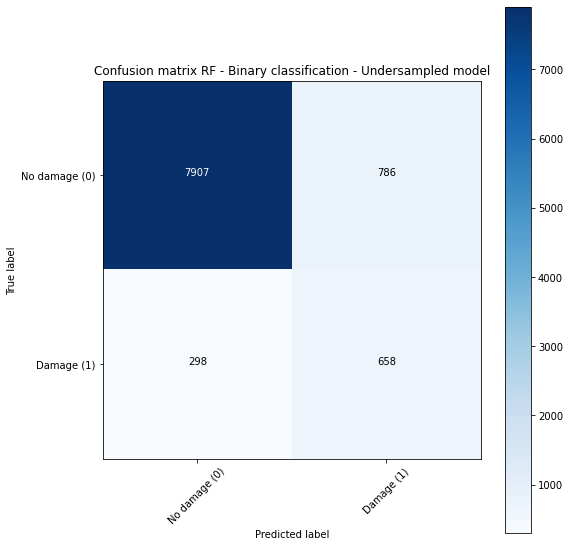

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rfc_binary_predict, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, rfc_binary_predict))

# Plot non-normalized confusion matrix
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes=['No damage (0)', 'Damage (1)'] ,normalize= False,  title='Confusion matrix RF - Binary classification - Undersampled model')
plt.savefig('/content/gdrive/MyDrive/TFM/plots/Machine_learning_models/RF_binary_classif_conf_matrix_undersampled.eps', bbox_inches="tight", format='eps')

In [ ]:
roc_auc_score(y_test, rfc_binary_predict)

0.7989334707336784